################# AD Click Prediction ####################

In [37]:
###########importing libraries ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV , train_test_split
from tqdm import tqdm_notebook
import warnings
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import gc
warnings.filterwarnings('ignore')
%matplotlib inline

In [38]:
#Setting working directory
import os
print(os.getcwd())

C:\Users\anjal\Desktop\amex-hackathon


In [39]:
os.chdir('C:\\Users\\anjal\\Desktop\\amex-hackathon')

In [40]:
print(os.getcwd())

C:\Users\anjal\Desktop\amex-hackathon


In [41]:
##########Loading the Data###############################

df = pd.read_csv('train.csv', parse_dates= ['DateTime'])
df_test = pd.read_csv('test.csv', parse_dates= ['DateTime'])
df_hist = pd.read_csv('historical_user_logs.csv', parse_dates= ['DateTime'])

In [42]:
#get header
cols=df.columns 
#get dimensions
print(df.shape) 

(463291, 15)


In [43]:
# print header and dataType, as well as boolean value which tells missing values
print(df.dtypes) 
print('ColumnName| DataType| MissingValues')
for i in cols:
    print(i, '|', df[i].dtype,'|',df[i].isnull().any())

session_id                         int64
DateTime                  datetime64[ns]
user_id                            int64
product                           object
campaign_id                        int64
webpage_id                         int64
product_category_1                 int64
product_category_2               float64
user_group_id                    float64
gender                            object
age_level                        float64
user_depth                       float64
city_development_index           float64
var_1                              int64
is_click                           int64
dtype: object
ColumnName| DataType| MissingValues
session_id | int64 | False
DateTime | datetime64[ns] | False
user_id | int64 | False
product | object | False
campaign_id | int64 | False
webpage_id | int64 | False
product_category_1 | int64 | False
product_category_2 | float64 | True
user_group_id | float64 | True
gender | object | True
age_level | float64 | True
user_depth | float

In [44]:
display(HTML(df.head(10).to_html()))

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,product_category_2,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,NaN,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,NaN,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,NaN,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,NaN,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,NaN,2.0,Male,2.0,3.0,2.0,1,0
5,151475,2017-07-02 00:01:00,509591,I,359520,13787,2,NaN,1.0,Male,1.0,3.0,NaN,0,0
6,17583,2017-07-02 00:01:00,1091463,F,405490,60305,3,NaN,9.0,Female,3.0,3.0,4.0,0,0
7,461128,2017-07-02 00:01:00,469098,C,360936,13787,3,NaN,4.0,Male,4.0,3.0,4.0,0,0
8,390699,2017-07-02 00:02:00,611906,H,105960,11085,5,270915.0,NaN,NaN,NaN,NaN,NaN,0,0
9,353607,2017-07-02 00:02:00,418107,B,360936,13787,2,NaN,4.0,Male,4.0,3.0,4.0,0,0


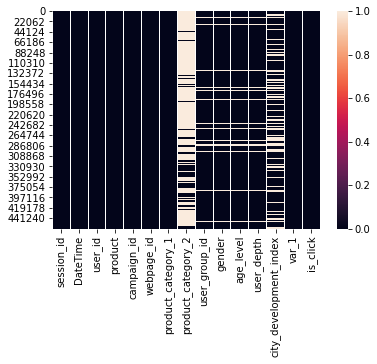

In [45]:
# visualize data for missing values

sns.heatmap(df.isnull())
#df.isnull().sum().plot(kind="barh")

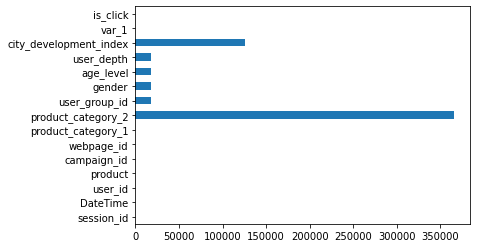

In [46]:
######Visualization showing the count of number of missing values in respective features

df.isnull().sum().plot(kind="barh")

In [47]:
#Checking for the count of values in product_category_2 

df['product_category_2'].count()

97437

In [48]:
#get dimensions of the whole data 
print(df.shape)

(463291, 15)


#Hence 97437 makes 21.04% of 463291 of data hence dropping this column

In [49]:
df = df.drop('product_category_2', axis = 1) # dropping the column

In [50]:
df.head() #checking the data for dropped data column

,session_id,DateTime,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click
0,140690,2017-07-02 00:00:00,858557,C,359520,13787,4,10.0,Female,4.0,3.0,3.0,0,0
1,333291,2017-07-02 00:00:00,243253,C,105960,11085,5,8.0,Female,2.0,2.0,NaN,0,0
2,129781,2017-07-02 00:00:00,243253,C,359520,13787,4,8.0,Female,2.0,2.0,NaN,0,0
3,464848,2017-07-02 00:00:00,1097446,I,359520,13787,3,3.0,Male,3.0,3.0,2.0,1,0
4,90569,2017-07-02 00:01:00,663656,C,405490,60305,3,2.0,Male,2.0,3.0,2.0,1,0


In [51]:
#Checking for the count of values in user_group_id

df['user_group_id'].count()

445048

#Hence 445048 makes 96.06% of 463291 of data hence will fill the remaining missing values in column

In [52]:
#Checking for the count of values in gender

df['gender'].count()

445048

#Hence 445048 makes 96.06% of 463291 of data hence will fill the remaining missing values in column

In [53]:
#Checking for the count of values in age_level

df['age_level'].count()

445048

#Hence 445048 makes 96.06% of 463291 of data hence will fill the remaining missing values in column

In [54]:
#Checking for the count of values in user_depth

df['user_depth'].count()

445048

#Hence 445048 makes 96.06% of 463291 of data hence will fill the remaining missing values in column

In [55]:
#Checking for the count of values in city_development_index

df['city_development_index'].count()

338162

#Hence 338162 makes 72.99% of 463291 of data hence will fill the remaining missing values in column

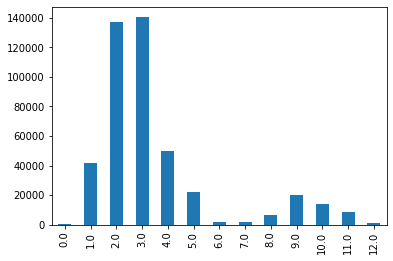

In [56]:
#visualizing the 'user_group_id' column to fill in the missing values by most frequent term
df['user_group_id'].value_counts().sort_index().plot.bar()

In [57]:
####Changing integer features (which are supposed to be categorical) to categorical features

df['session_id'] = df['session_id'].astype(object)
df['user_id'] = df['user_id'].astype(object)
df['campaign_id'] = df['campaign_id'].astype(object)
df['webpage_id'] = df['webpage_id'].astype(object)
df['product_category_1'] = df['product_category_1'].astype(object)
df['user_group_id'] = df['user_group_id'].astype(object)
df['age_level'] = df['age_level'].astype(object)
df['user_depth'] = df['user_depth'].astype(object)
df['city_development_index'] = df['city_development_index'].astype(object)
df['var_1'] = df['var_1'].astype(object)
df['is_click'] = df['is_click'].astype(object)

In [58]:
# Checking for the unique value for 'user_group_id'
df.user_group_id.unique()

array([10.0, 8.0, 3.0, 2.0, 1.0, 9.0, 4.0, nan, 11.0, 7.0, 5.0, 12.0, 6.0,
       0.0], dtype=object)

In [59]:
#replacing the nan and '0' value with '3' as it is the most frequent term
df['user_group_id'] = df['user_group_id'].fillna(3)

In [60]:
df.user_group_id.replace([0], [3], inplace=True)

In [61]:
df.user_group_id.unique()

array([10.,  8.,  3.,  2.,  1.,  9.,  4., 11.,  7.,  5., 12.,  6.])

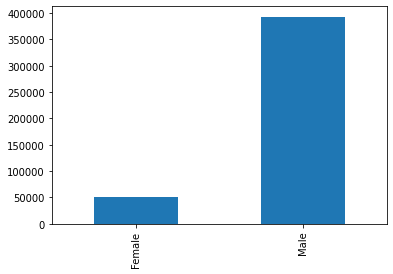

In [62]:
#visualizing the 'gender' column to fill in the missing values by most frequent term
df['gender'].value_counts().sort_index().plot.bar()

In [63]:
#fill the missing values in the gender column by the 'Male' term in the gender column
df['gender'] = df['gender'].fillna("Male")

In [64]:
#checking the values in user_group_id
df['gender'].count()

463291

In [65]:
df.gender.unique()

array(['Female', 'Male'], dtype=object)

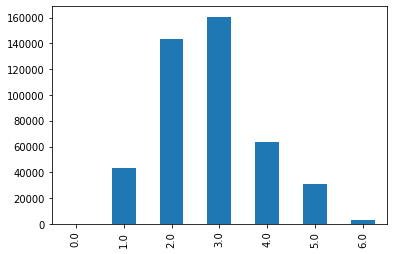

In [66]:
#visualizing the 'age_level' column to fill in the missing values by most frequent term
df['age_level'].value_counts().sort_index().plot.bar()

In [67]:
df.age_level.unique()

array([4.0, 2.0, 3.0, 1.0, nan, 5.0, 6.0, 0.0], dtype=object)

In [68]:
#converting the 'age_level' into categorical and replacing the missing value by the most repeating
#value that is 3
df['age_level'] = df['age_level'].fillna(3)

In [69]:
#checking the values in user_group_id
df['age_level'].count()

463291

In [70]:
df.age_level.unique()

array([4., 2., 3., 1., 5., 6., 0.])

In [71]:
#Replacing the '0' value with '3' in age_level

df.age_level.replace([0], [3], inplace=True)

#Hence 445048 makes 96.06% of 463291 of data hence will fill the remaining missing values in column

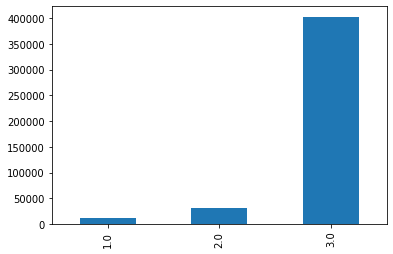

In [72]:
#calculating the mean value to fill missing value for user_depth
df['user_depth'].value_counts().sort_index().plot.bar()

In [73]:
#checking the unique values in the columns
df.user_depth.unique()

array([3.0, 2.0, nan, 1.0], dtype=object)

In [74]:
#converting the 'user_depth' into categorical and replacing the missing value by the most repeating
#value that is 3
df['user_depth'] = df['user_depth'].astype(object)
df['user_depth'] = df['user_depth'].fillna(3)

In [75]:
#checking the new unique values in user_depth
df.user_depth.unique()

array([3., 2., 1.])

In [76]:
#Checking for the count of values in city_development_index

df['city_development_index'].count()

338162

#Hence 338162 makes 72.99% of 463291 of data hence will fill the remaining missing values in column

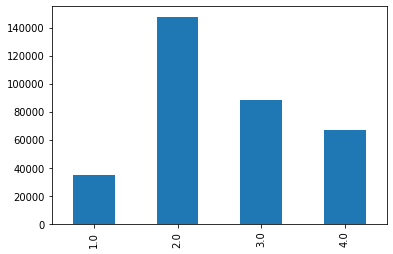

In [77]:
#visualizing the 'city_development_index' column to fill in the missing values by most frequent term
df['city_development_index'].value_counts().sort_index().plot.bar()

In [78]:
#checking for the unique values in the column
df.city_development_index.unique()

array([3.0, nan, 2.0, 4.0, 1.0], dtype=object)

In [79]:
#converting the 'city_development_index' into categorical and replacing the missing value by the most repeating
#value that is 2
df['city_development_index'] = df['city_development_index'].fillna(2)

In [80]:
#checking for the unique values in the column
df.city_development_index.unique()

array([3., 2., 4., 1.])

In [82]:
attributes = df.columns
print('ColumnName, DataType, MissingValues')
for i in attributes:
    print(i, ',', df[i].dtype,',',df[i].isnull().any())

ColumnName, DataType, MissingValues
session_id , object , False
DateTime , datetime64[ns] , False
user_id , object , False
product , object , False
campaign_id , object , False
webpage_id , object , False
product_category_1 , object , False
user_group_id , float64 , False
gender , object , False
age_level , float64 , False
user_depth , float64 , False
city_development_index , float64 , False
var_1 , object , False
is_click , object , False


In [122]:
df.to_csv(r'C:\Users\goswa\Documents\Python4DataAnalytics\Project\pdata.csv', index = False)

In [163]:
#Copying the main 'df' into 'df_nb'

dataFrame=df.copy(deep=True) 

#Visualizing the Data 

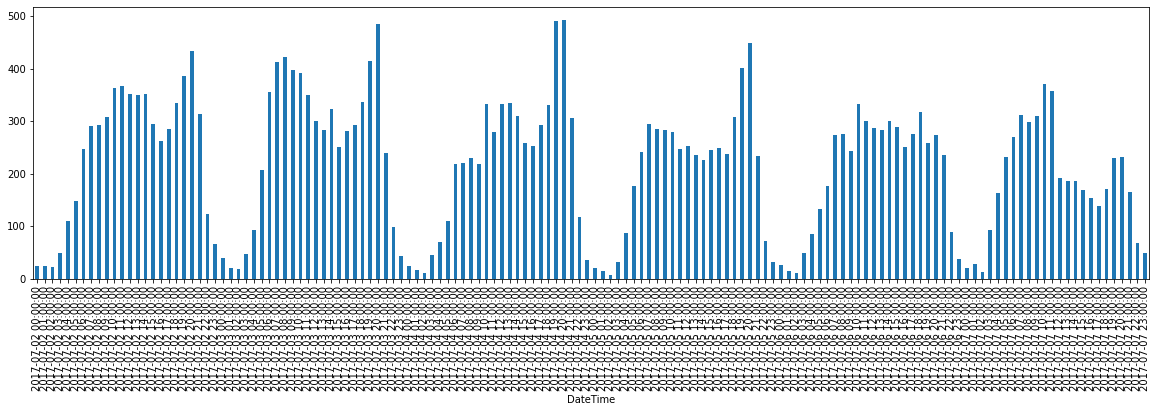

In [164]:
day = dataFrame.groupby('DateTime')['is_click'].sum()
day = day.resample('H').sum()
plt.figure(figsize=(20,5))
day.plot(kind='bar',grid = None)

Visualizing the trends in the data by setting granularity to per hour on daily basis


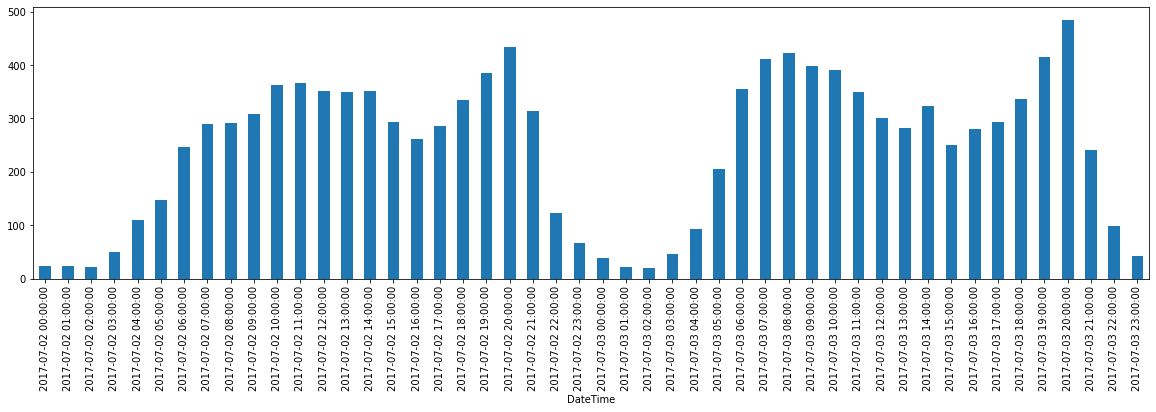

In [165]:
part_day = day.loc[slice('2017-07-02','2017-07-03')]
plt.figure(figsize=(20,5))
part_day.plot(kind='bar',grid = None)

Portion of the above plot for 2 days of user data.

#Visualizing the user behavior on weekday basis. It seems that most of the clicks are for MONDAY & SUNDAY.

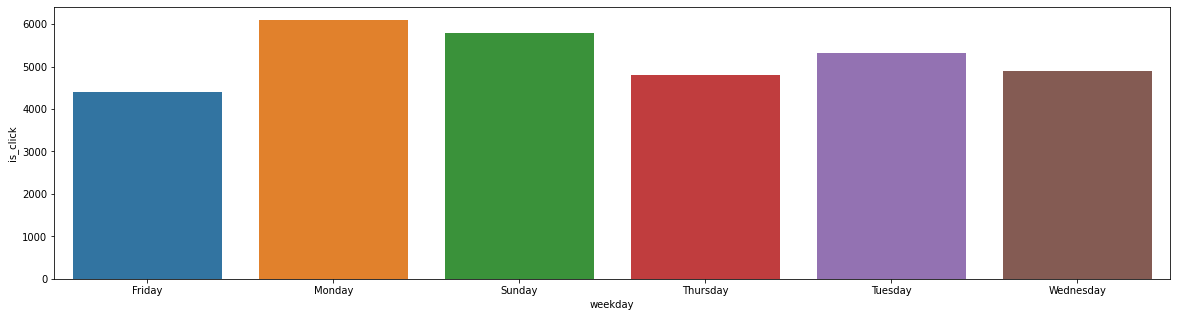

In [166]:
data1 = dataFrame.reset_index()
data1['weekday'] = data1['DateTime'].dt.day_name()
byday  = pd.DataFrame(data1.groupby('weekday')['is_click'].sum())
byday = byday.reset_index()
plt.figure(figsize=(20,5))
sns.barplot(data = byday , x= 'weekday', y = 'is_click')

Visualizing data for different products for male and female user groups.

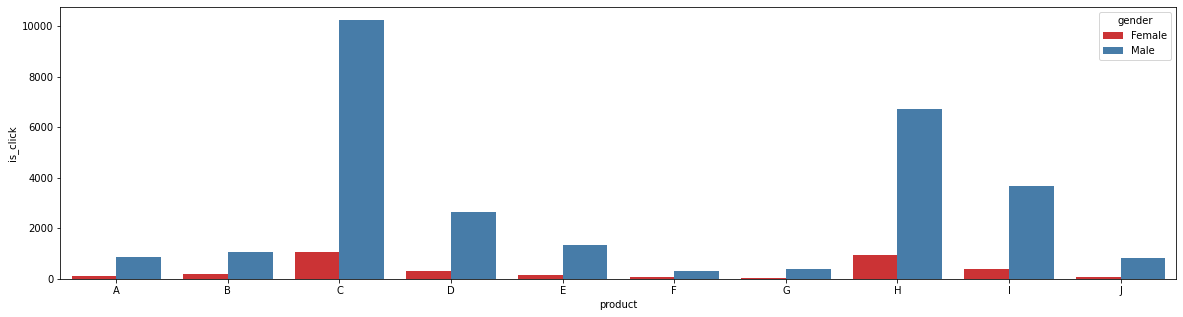

In [167]:
user = dataFrame.groupby(['gender','product'])['is_click'].sum()
user = pd.DataFrame(user.reset_index())
plt.figure(figsize=(20,5))
sns.barplot(data = user, x= 'product', y = 'is_click', hue = 'gender',palette='Set1')

#Barplot showing max clicks for all the product from a single campaign.

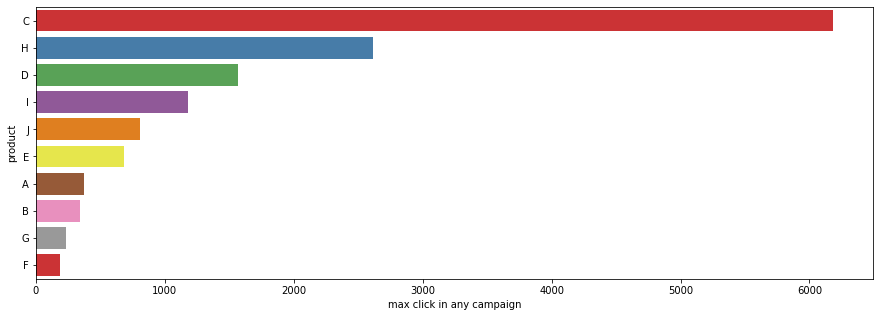

In [168]:
n_data = dataFrame.reset_index()
campaign= pd.DataFrame(n_data.groupby(['campaign_id','product'])['is_click'].sum())
campaign= campaign.reset_index()
campaign= campaign.groupby(['product'])[['campaign_id','is_click']].max()
campaign= campaign.sort_values('is_click',ascending = False).reset_index()
campaign.columns = ['product', 'campaign_id', 'max click in any campaign']
plt.figure(figsize=(15,5))
sns.barplot(y= 'product', x= 'max click in any campaign', palette = 'Set1', data = campaign, orient='h')

#Table highlighting the most successful product and no. of clicks for each of them for each campaign.

In [169]:
n_data = dataFrame.reset_index()
campaign= pd.DataFrame(n_data.groupby(['campaign_id','product'])['is_click'].sum())
campaign= campaign.reset_index()
campaign= campaign.groupby('campaign_id')[['product','is_click']].max()
campaign.sort_values('is_click',ascending = False)

,product,is_click
campaign_id,,
405490,H,6183
359520,I,2796
98970,I,1566
360936,I,1293
396664,J,1182
118601,I,816
404347,J,805
105960,I,749
414149,I,610


#This visualization highlights that all the user groups from 0-6 are Male and from 7-12 are Females.

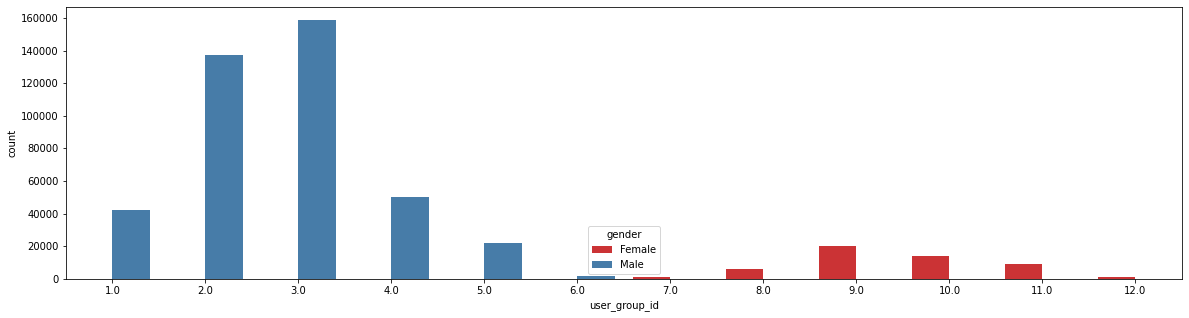

In [170]:
plt.figure(figsize=(20,5))
sns.countplot(x= 'user_group_id', hue= 'gender', palette = 'Set1', data = dataFrame)

#Successs % on the basis of the user id group. Most successful user group is 12.

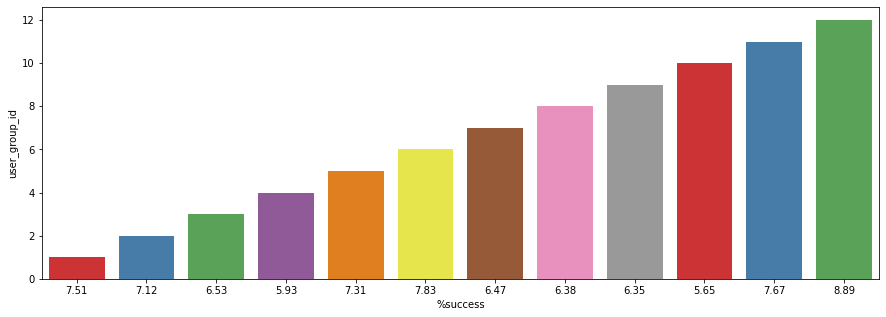

In [171]:
plt.figure(figsize=(15,5))
user_group = dataFrame.groupby('user_group_id')['is_click'].agg(['count','sum'])
user_group['%success']= round((user_group['sum']*100)/user_group['count'], 2)
user_group = user_group.reset_index()
sns.barplot(y= 'user_group_id', x= '%success', data = user_group, palette = 'Set1', order = user_group['%success'])

#Visualizing count of clicks and non clicks for each of the product.

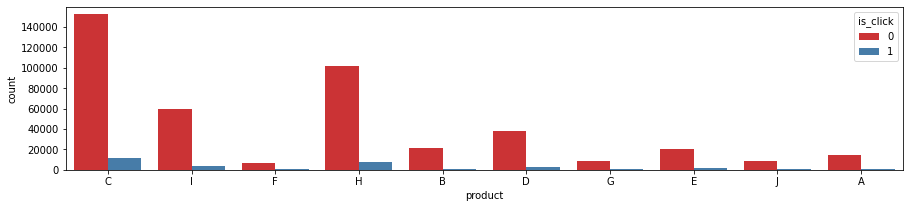

In [172]:
plt.figure(figsize=(15,3))
sns.countplot(x="product", hue= "is_click", palette = 'Set1', data =dataFrame )

#Performance of all the products compared category wise.

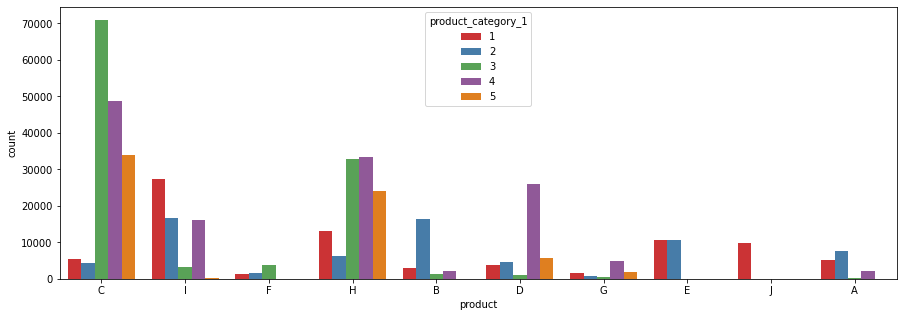

In [173]:
plt.figure(figsize=(15,5))
sns.countplot(x="product", hue= "product_category_1", palette = 'Set1', data =dataFrame)

In [156]:
# Checking for Data Imbalance

In [174]:
data1 = dataFrame[['user_depth', 'is_click']]
data1 = dataFrame.groupby(['user_depth','is_click']).size().unstack()
data1['success %'] = round(data1[1]*100/(data1[1]+data1[0]),2)
data1

is_click,0,1,success %
user_depth,,,
1.0,11008,853,7.19
2.0,28398,1991,6.55
3.0,392554,28487,6.77


In [175]:
print(dataFrame['is_click'].value_counts())
print(round(30057*100/(414991),2))  

0    431960
1     31331
Name: is_click, dtype: int64
7.24


#Number of clicks is only 7.24%. So, our dataset is imbalanced

#Data Preprocessing & Feature Engineering 

In [176]:
#droping the sessionId & DateTime Converting Date time into hours, days & Minutes
dataFrame['weekday']=dataFrame['DateTime'].dt.day_name()
dataFrame['hour'] = dataFrame['DateTime'].dt.hour
dataFrame['minutes'] = dataFrame['DateTime'].dt.minute
dataFrame = dataFrame.drop(['DateTime','session_id'], axis = 1)
dataFrame.head()

,user_id,product,campaign_id,webpage_id,product_category_1,user_group_id,gender,age_level,user_depth,city_development_index,var_1,is_click,weekday,hour,minutes
0,858557,C,359520,13787,4,10,Female,4,3,3,0,0,Sunday,0,0
1,243253,C,105960,11085,5,8,Female,2,2,2,0,0,Sunday,0,0
2,243253,C,359520,13787,4,8,Female,2,2,2,0,0,Sunday,0,0
3,1097446,I,359520,13787,3,3,Male,3,3,2,1,0,Sunday,0,0
4,663656,C,405490,60305,3,2,Male,2,3,2,1,0,Sunday,0,1


In [177]:
#Working on the Historical Logs Data
df_hist.head()

,DateTime,user_id,product,action
0,2017-05-28 15:44:00,704,B,view
1,2017-05-29 07:08:00,499679,F,view
2,2017-05-29 07:10:00,499679,G,view
3,2017-05-29 07:10:00,499679,G,view
4,2017-05-29 07:10:00,499679,G,view


In [178]:
df_hist['user_id'] = df_hist['user_id'].astype(object)

In [179]:
import featuretools as ft
es1 = ft.EntitySet()

In [180]:
es1.entity_from_dataframe(entity_id="hist",
                         index="id",
                        time_index="DateTime",
                         dataframe=df_hist)

2020-04-24 14:58:42,121 featuretools.entityset - WARNING    index id not found in dataframe, creating new integer column


Entityset: None
  Entities:
    hist [Rows: 24287534, Columns: 5]
  Relationships:
    No relationships

In [181]:
es1['hist'].variables

[<Variable: id (dtype = index)>,
 <Variable: DateTime (dtype: datetime_time_index, format: None)>,
 <Variable: user_id (dtype = categorical)>,
 <Variable: product (dtype = categorical)>,
 <Variable: action (dtype = categorical)>]

In [182]:
es1 = es1.entity_from_dataframe(entity_id = 'data', 
                                dataframe= dataFrame, 
                                make_index= True, 
                                index = 'id',
                                variable_types={"user_id": ft.variable_types.Categorical, 
                                                'webpage_id': ft.variable_types.Categorical,
                                                'campaign_id': ft.variable_types.Categorical,
                                                'product_category_1': ft.variable_types.Categorical,
                                                'user_group_id':  ft.variable_types.Categorical,
                                                'age_level': ft.variable_types.Categorical,
                                                'user_depth': ft.variable_types.Categorical,
                                                'city_development_index': ft.variable_types.Categorical,
                                                'var_1': ft.variable_types.Categorical ,
                                                'is_click': ft.variable_types.Categorical
                                               })          

In [183]:
es1['data'].variables

[<Variable: id (dtype = index)>,
 <Variable: product (dtype = categorical)>,
 <Variable: gender (dtype = categorical)>,
 <Variable: weekday (dtype = categorical)>,
 <Variable: hour (dtype = numeric)>,
 <Variable: minutes (dtype = numeric)>,
 <Variable: user_id (dtype = categorical)>,
 <Variable: webpage_id (dtype = categorical)>,
 <Variable: campaign_id (dtype = categorical)>,
 <Variable: product_category_1 (dtype = categorical)>,
 <Variable: user_group_id (dtype = categorical)>,
 <Variable: age_level (dtype = categorical)>,
 <Variable: user_depth (dtype = categorical)>,
 <Variable: city_development_index (dtype = categorical)>,
 <Variable: var_1 (dtype = categorical)>,
 <Variable: is_click (dtype = categorical)>]

In [184]:
relation = ft.Relationship(es1['data']['id'], es1['hist']['id'])

In [185]:
es1 = es1.add_relationship(relation)
es1

Entityset: None
  Entities:
    hist [Rows: 24287534, Columns: 5]
    data [Rows: 463291, Columns: 16]
  Relationships:
    hist.id -> data.id

In [186]:
features, feature_names = ft.dfs(entityset= es1, 
                                 target_entity= 'data', 
                                  max_depth = 2
                                 )

In [188]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463291 entries, 0 to 463290
Data columns (total 29 columns):
product                               463291 non-null object
gender                                463291 non-null object
weekday                               463291 non-null object
hour                                  463291 non-null int64
minutes                               463291 non-null int64
user_id                               463291 non-null object
webpage_id                            463291 non-null object
campaign_id                           463291 non-null object
product_category_1                    463291 non-null object
user_group_id                         463291 non-null object
age_level                             463291 non-null object
user_depth                            463291 non-null object
city_development_index                463291 non-null object
var_1                                 463291 non-null object
is_click                             

In [215]:
features['user_id'] = features['user_id'].astype('int')
features['webpage_id'] = features['webpage_id'].astype('int')
features['campaign_id']= features['campaign_id'].astype('int')
features['product_category_1'] = features['product_category_1'].astype('int')
features['user_group_id'] = features['user_group_id'].astype('int')
features['age_level'] = features['age_level'].astype('int')
features['user_depth'] = features['user_depth'].astype('int')
features['city_development_index'] = features['city_development_index'].astype('int')
features['var_1'] = features['var_1'].astype('int')
features['is_click'] = features['is_click'].astype('int')

In [216]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463291 entries, 0 to 463290
Data columns (total 29 columns):
product                               463291 non-null object
gender                                463291 non-null object
weekday                               463291 non-null object
hour                                  463291 non-null int64
minutes                               463291 non-null int64
user_id                               463291 non-null int32
webpage_id                            463291 non-null int32
campaign_id                           463291 non-null int32
product_category_1                    463291 non-null int32
user_group_id                         463291 non-null int32
age_level                             463291 non-null int32
user_depth                            463291 non-null int32
city_development_index                463291 non-null int32
var_1                                 463291 non-null int32
is_click                              463291 n

In [219]:
col =['product','gender','weekday','webpage_id','campaign_id','product_category_1','user_group_id','age_level','user_depth','var_1','city_development_index','MODE(hist.product)','MODE(hist.action)']
new_data = pd.get_dummies(features, columns = col, drop_first= True)

In [220]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463291 entries, 0 to 463290
Data columns (total 84 columns):
hour                                  463291 non-null int64
minutes                               463291 non-null int64
user_id                               463291 non-null int32
is_click                              463291 non-null int32
NUM_UNIQUE(hist.action)               463291 non-null int64
NUM_UNIQUE(hist.product)              463291 non-null int64
NUM_UNIQUE(hist.user_id)              463291 non-null int64
MODE(hist.user_id)                    463291 non-null int64
NUM_UNIQUE(hist.MONTH(DateTime))      463291 non-null int64
NUM_UNIQUE(hist.WEEKDAY(DateTime))    463291 non-null int64
NUM_UNIQUE(hist.YEAR(DateTime))       463291 non-null int64
NUM_UNIQUE(hist.DAY(DateTime))        463291 non-null int64
MODE(hist.MONTH(DateTime))            463291 non-null int64
MODE(hist.WEEKDAY(DateTime))          463291 non-null int64
MODE(hist.YEAR(DateTime))             463291 non-

In [221]:
X = new_data.drop('is_click', axis=1)
y = new_data['is_click']

In [222]:
y = y.astype('int')
X = X.astype('int')

In [223]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3,  stratify = y,random_state = 101)

In [224]:
train = pd.concat([X_train, y_train], axis = 1)

In [225]:
t_0 = train[train['is_click'] == 0]
t_1 = train[train['is_click'] == 1]

Working with a subset of Training Data & Oversample the data to tackle Data Imbalance

In [226]:
t0_sub = t_0.sample(n = 27573, random_state= 101)
t1_sub = t_1.sample(n = 2000, random_state= 101)
train_sub = pd.concat([t0_sub,t1_sub], axis = 0)
train_sub = train_sub.sample(frac=1, random_state= 101)

In [227]:
Xtr_sub = train_sub.drop('is_click', axis=1)
ytr_sub = train_sub['is_click']

In [228]:
from imblearn.over_sampling import SMOTE

In [229]:
sm = SMOTE(random_state = 101)
X_sub, y_sub  = sm.fit_sample(Xtr_sub,ytr_sub)

In [230]:
X_sub.shape, y_sub.shape

((55146, 83), (55146,))

#Feature Selection

In [231]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [232]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=75, verbose= 1)
fit = rfe.fit(X_sub,y_sub)

Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.


In [233]:
sum(fit.support_)

75

In [234]:
X_sub = pd.DataFrame(X_sub, columns= Xtr_sub.columns)
X_sub = np.array(X_sub.loc[:,fit.support_])
X_sub.shape

(55146, 75)

,product,gender,weekday,hour,minutes,user_id,webpage_id,campaign_id,product_category_1,user_group_id,age_level,user_depth,city_development_index,var_1,is_click,NUM_UNIQUE(hist.action),NUM_UNIQUE(hist.product),NUM_UNIQUE(hist.user_id),MODE(hist.action),MODE(hist.product),MODE(hist.user_id),NUM_UNIQUE(hist.MONTH(DateTime)),NUM_UNIQUE(hist.WEEKDAY(DateTime)),NUM_UNIQUE(hist.YEAR(DateTime)),NUM_UNIQUE(hist.DAY(DateTime)),MODE(hist.MONTH(DateTime)),MODE(hist.WEEKDAY(DateTime)),MODE(hist.YEAR(DateTime)),MODE(hist.DAY(DateTime))
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,C,Female,Sunday,0,0,858557,13787,359520,4,10,4,3,3,0,0,1,1,1,view,B,704,1,1,1,1,5,6,2017,28
1,C,Female,Sunday,0,0,243253,11085,105960,5,8,2,2,2,0,0,1,1,1,view,F,499679,1,1,1,1,5,0,2017,29
2,C,Female,Sunday,0,0,243253,13787,359520,4,8,2,2,2,0,0,1,1,1,view,G,499679,1,1,1,1,5,0,2017,29
3,I,Male,Sunday,0,0,1097446,13787,359520,3,3,3,3,2,1,0,1,1,1,view,G,499679,1,1,1,1,5,0,2017,29
4,C,Male,Sunday,0,1,663656,60305,405490,3,2,2,3,2,1,0,1,1,1,view,G,499679,1,1,1,1,5,0,2017,29
5,I,Male,Sunday,0,1,509591,13787,359520,2,1,1,3,2,0,0,1,1,1,view,G,499679,1,1,1,1,5,0,2017,29
6,F,Female,Sunday,0,1,1091463,60305,405490,3,9,3,3,4,0,0,1,1,1,view,G,499679,1,1,1,1,5,0,2017,29
7,C,Male,Sunday,0,1,469098,13787,360936,3,4,4,3,4,0,0,1,1,1,view,G,499679,1,1,1,1,5,0,2017,29
8,H,Male,Sunday,0,2,611906,11085,105960,5,3,3,3,2,0,0,1,1,1,view,G,499679,1,1,1,1,5,0,2017,29


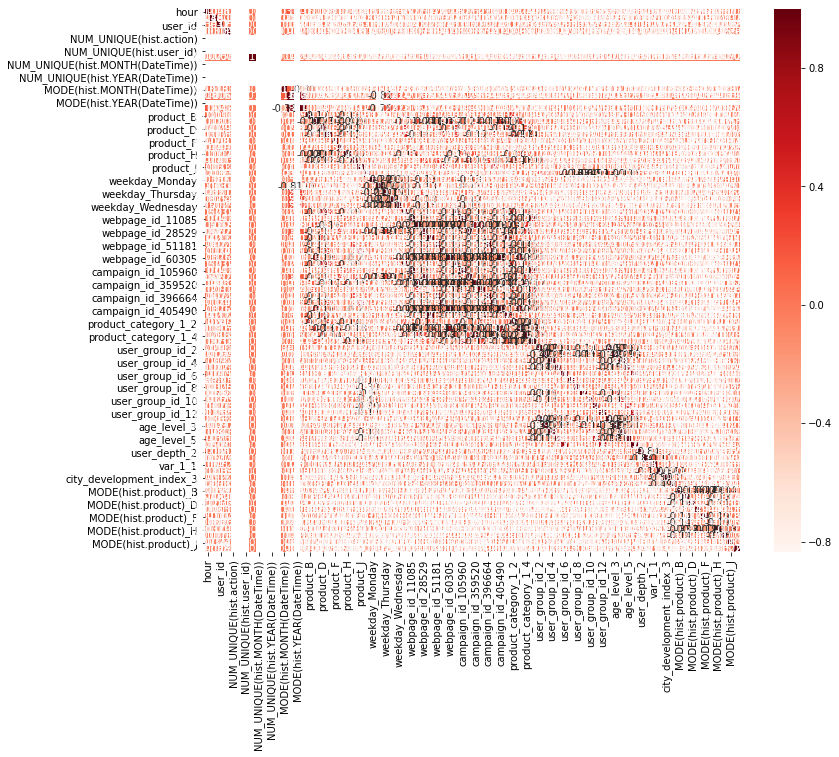


Selected features by Filter model:
 is_click    1.0
Name: is_click, dtype: float64


In [242]:
import matplotlib.pyplot as plt

# print out and display dataframe as tables in HTML
display(HTML(features.head(10).to_html()))

# set features and labels
x = X_sub
y = y_sub

# calculate correlation and show in heatmap
plt.figure(figsize=(12,10))
cor = new_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#Correlation with output variable
cor_target = abs(cor["is_click"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print('\nSelected features by Filter model:\n',relevant_features)